In [41]:
# Multiple outputs per cell in Jupyter 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [42]:
%%javascript
// Evitar autoscroll.
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
from skeleton import *
from sklearn.metrics import (recall_score, f1_score,
                             precision_score, accuracy_score)

In [ ]:
# Creamos y entrenamos una instancia del clasificador, utilizaremos la partición 
# de entrenamiento X_train, y_train
blobs_clf=NearestCentroid(distance='euclidiana',centroid_type="Average").fit(blobs_X_train,blobs_y_train)

In [ ]:
# Tenemos un conjunto de centroides por clase (2 para ejemplo)
blobs_clf.centroids_

In [ ]:
# Reutilizamos plotClusters para ver los centroides
plotClusters(blobs_X_train,blobs_y_train,blobs_clf.centroids_)

In [ ]:
# Podemos predeccir las etiquetas del conjunto de prueba
blobs_yp=blobs_clf.predict(blobs_X_test)

In [ ]:
blobs_yp

In [ ]:
# Como es un ejemplo de juguete todo perfecto!
print("Etiquetas predecidad:", blobs_yp)
print("Etiquetas verdaderas:", blobs_y_test)

In [ ]:
# Podemos utilizar las métricas de precision, recall y accuracy
print("Recall: ", recall_score(blobs_y_test,blobs_yp))
print("F1: ", f1_score(blobs_y_test,blobs_yp))
print("Precision: ", precision_score(blobs_y_test,blobs_yp))

In [ ]:
x1,x2,x3=np.array([1,100]),np.array([3,1]),np.array([2,100])
x1,x2,x3
x1+x2+x3
np.linalg.norm(x1+x2+x3)
(x1+x2+x3)/np.linalg.norm(x1+x2+x3)
print("======")
x1/np.linalg.norm(x1)
x2/np.linalg.norm(x2)
x3/np.linalg.norm(x3)
(x1/np.linalg.norm(x1))+(x2/np.linalg.norm(x2))+(x3/np.linalg.norm(x3))

In [ ]:
# Creamos y entrenamos una instancia del clasificador, utilizaremos la partición 
# de entrenamiento X_train, y_train# Podemos predeccir las etiquetas del conjunto de prueba
blobs_clf=NearestCentroid(distance='euclidiana',centroid_type="NormSum").fit(blobs_X_train,blobs_y_train)

In [ ]:
# Tenemos un conjunto de centroides por clase (2 para ejemplo)
blobs_clf.centroids_

In [ ]:
# Reutilizamos plotClusters para ver los centroides
plotClusters(blobs_X_train,blobs_y_train,blobs_clf.centroids_)

In [ ]:
# Podemos predeccir las etiquetas del conjunto de prueba
blobs_yp=blobs_clf.predict(blobs_X_test)

In [ ]:
blobs_yp

In [ ]:
# Como es un ejemplo de juguete todo perfecto!
print("Etiquetas predecidad:", blobs_yp)
print("Etiquetas verdaderas:", blobs_y_test)

In [ ]:
# Podemos utilizar las métricas de precision, recall y accuracy
print("Recall: ", recall_score(blobs_y_test,blobs_yp))
print("F1: ", f1_score(blobs_y_test,blobs_yp))
print("Precision: ", precision_score(blobs_y_test,blobs_yp))

Probemos con un ejemplo un poco diferente

In [ ]:
#Generamos los datos
circles_X,circles_y= make_circles(n_samples=300, noise=0.1, random_state=2, factor=0.3)
plotClusters(circles_X,circles_y)

In [ ]:
#Particionamos en train y test
circles_X_train,circles_X_test, circles_y_train, circles_y_test = train_test_split(circles_X, circles_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=circles_y)

In [ ]:
# Instanciamos y entremamos un clasificacor nearest centroids
circles_clf=NearestCentroid(centroid_type="Rocchio").fit(circles_X_train,circles_y_train)

In [ ]:
# Graficamos con los centroides
plotPCA(circles_X_train,circles_y_train,centroids=circles_clf.centroids_,vectors=False)

In [ ]:
#Veamos que tan bien lo hace nearest centroid
circles_yp=circles_clf.predict(circles_X_test)
print("Recall: ", recall_score(circles_y_test,circles_yp))
print("F1: ", f1_score(circles_y_test,circles_yp))
print("Precision: ", precision_score(circles_y_test,circles_yp))

Los resultados son incluso peor que lanzar una moneada. Esto ocurre dado que NC es un método lineal de clasificación y el segundo caso es claramente un conjunto de datos no lineal. La frontera de clasificación en ambos casos es lineal. 

In [ ]:
# Frontera para las blobs 
plotDecisionBoundary(blobs_clf,blobs_X_train,blobs_y_train)

In [ ]:
# Frontera para los circulos
plotDecisionBoundary(circles_clf,circles_X_train,circles_y_train)

Aún cuando en los casos no lineales, no funciona bien, la buena noticia es que para problemas de dimensiones grandes (como el caso de texto) los clasificadores lineales se desempeñan bien. Como último ejemplo mostramos cómo aplicar el método al problema de clasificación de flores de Iris. El conjunto de datos consite de:

- 150 ejemplos.
- 3 clases: Iris setosa, Iris virginica y  Iris versicolor
- 4 caraterísticas: longitud del sépalo, ancho del sépalo, longitud del pétalo y ancho del pétalo. 

|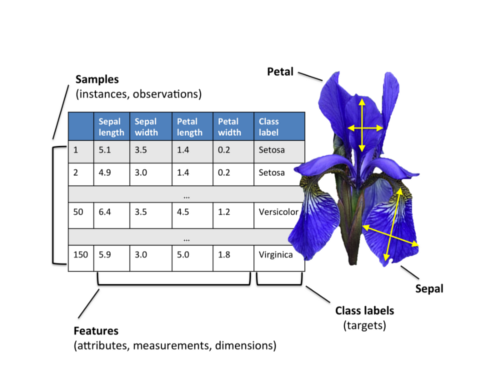|
|:--:|
|**Iris Dataset** |

In [ ]:
## Cargamos el dataset de plantas de Iris
iris = load_iris()
iris_X, iris_y = iris.data, iris.target
#Divididmos en entremamiento y prueba
iris_X_train, iris_X_test, iris_y_train, iris_y_test = train_test_split(iris_X, iris_y,
                                                    test_size=0.30,
                                                    random_state=3,
                                                    stratify=iris_y)

In [ ]:
# Instanciamos y entremamos un clasificacor nearest centroids
iris_clf=NearestCentroid(distance='coseno').fit(iris_X_train,iris_y_train)

In [ ]:
# Los centroides son en 4 dimensiones
iris_clf.centroids_

In [ ]:
# Predecimos las etiquetas del conjunto de prueba
iris_yp=iris_clf.predict(iris_X_test)
# Medidas de bondad
print("Recall: ", recall_score(iris_y_test,iris_yp,average='macro'))
print("F1: ", f1_score(iris_y_test,iris_yp,average='macro'))
print("Precision: ", precision_score(iris_y_test,iris_yp,average='macro'))

In [ ]:
# Limite de decisión proyectado con PCA, recuerde que los elemetos son de dimension 4
plotDecisionBoundary(iris_clf,iris_X_train,iris_y_train)

## Clasificador $k$ Nearest Neighbor

El clasificador $k$ nearest neighbor ($k$NN), es un método no paramétrico que utiliza todos ejemplos en el conjunto de entrenamiento para predecir la clase de los ejemplos no etiquetados. Por lo que no hay fase de entrenamiento, la predicción se realiza mediante el uso de una función de similitud/distancia.

El clasificador $k$NN es simple e intuitivo, para $k=1$ funciona como sigue: dado un vector $x_q$, se le asocia la clase $\theta_q$ que será la misma que tenga el elemento más similar a $x_{nn} \in X$ más similar a $x_q$. El objeto $x_{nn}$ se determina como  $\arg\!\max_{1 \leq i \leq |X|} \cos (x_q, x_i)$ cuando se utiliza la similitud coseno o bien como $\arg\!\min_{1 \leq i \leq |X|} d(u, x_i)$  cuando se utiliza una función de distancia. Lo anterior da el origen al nombre desde que para determinar la clase de un objeto no etiquetado, primero debe encontrarse su vecino más cercano.  Una mejora directa es utilizar más de un vecino para calcular la clase de $x_q$, es decir utilizar $k>1$. Para $k>1$ se puede asignar a $x_q$ la clase que más se repita entre los $k$ vecinos más cercanos de $x_q$ (**pesado uniforme**).

|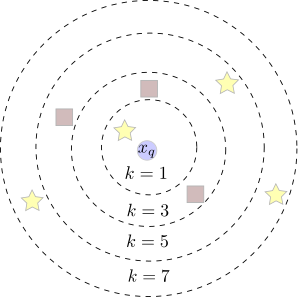|
|:--:|
|**Consulta $k$NN para diferentes valores de $k$**|

### Pesado de vecinos por distancia

También es común realizar un pesado de la contribución de cada vecino basados en el valor de la función de distancia o similitud. Para nuestro caso solo utilizaremos dos variantes simples. 

-  **$k$NN distancia/similitud media**: En este caso se asigna a  $x_q$ la clase en la que la distancia media de los $k$ vecinos seleccionados sea menor. Mientras que se utiliza el valor mayor cuando se utiliza una función de similitud.
- **$k$NN pesado por distancia**: Una forma básica de pesar cuando se utiliza una función de distancia es asignar a cada etiqueta un peso equivalente al inverso de la distancia. En el caso de la similitud puede ser el valor normalizado de la misma(cuando se usa coseno el valor ya está entre 0 y 1). Se asigna la clase que tenga el mayor peso.

Por ejemplo suponga que la información de cinco vecinos más cercanos para un $x_q$ dado en problema de 3 clases se resumen en la siguiente tabla. 

|&nbsp;|$x_1$|$x_2$|$x_3$|$x_4$|$x_5$|
|:------------:|:---:|:---:|:---:|:---:|:---:|
|Clase de $x_i$|  2  |  1  |  2  |  1  |  0  |
|$$d(x_i,x_q)$$| 0.5 | 0.2 |0.25 | 0.4 |0.125|
|$$w_{x_i}$$       |  2  |  5  |  4  | 2.5 |  8  |

en las siguiente tabla se muestra como se calculan los scores para cada clase

| <br /> | distancia media                    | pesado por distancia |uniforme|
|:------:|:---------------------------------: |:--------------:       |:----:|
|Clase 0 |  $d(x_5,x_q)/1$=**0.125**          |$w_{x_0}$=**8**            |   1  |
|Clase 1 |  $$(d(x_2,x_q)+d(x_4,x_q))/2=0.3$$   |$$w_{x_2}+w_{x_4}=7.5$$|   **2**  |
|Clase 2 |  $$(d(x_1,x_q)+d(x_3,x_q))/2=0.225$$ |$$w_{x_1}+w_{x_3}=6$$  |   **2**  |

usando la información en la tabla anterior podemos ver que para $k=5$, si se utiliza el criterio de la distancia mínimo promedio la clase para $x_q$ sería 0, al igual que para el pesado por distancia; mientras que para la decisión por mayoría de votos podría ser la clase 1 o 2. 

**Nota**: Si se utiliza una función de similitud no es necesario calcular el inverso, pero es buena idea normalizar.

- Se proporciona solución  mediante el uso de indices implementados en la librería **faiss**. En este caso la fase de entrenamiento consiste en generar el indice para los datos de entrenamiento.
- La versión **bruta/lineal** de $k$NN,  cada que se predice se debe calcular la distancia con respecto a todos los elementos en el conjunto de entrenamiento para determinar los $k$  más cercano. En este caso la fase de entrenamiento no se realiza, pero la predicción es costosa.


In [ ]:
#Probamos el clasificador con pesado uniforme con el ejemplo de los blobs
nn_clf=kNN(k=3,weight_type="weighedDist").fit(blobs_X_train,blobs_y_train)
plotDecisionBoundary(nn_clf,blobs_X_train,blobs_y_train)

In [ ]:
#Probamos el clasificador con pesado uniforme con el ejemplo de los blobs
nn_clf=kNN(k=3,weight_type="uniform").fit(blobs_X_train,blobs_y_train)
plotDecisionBoundary(nn_clf,blobs_X_train,blobs_y_train)

In [ ]:
#El data set de Iris
nn_clf=kNN(k=3,weight_type="uniform").fit(iris_X_train,iris_y_train)
plotDecisionBoundary(nn_clf,iris_X_train,iris_y_train)

In [ ]:
#Dataser de los circulos, utilizando distancia euclidiana
nn_clf=kNN(distance='euclideana', 
           k=3,weight_type="uniform").fit(circles_X_train,circles_y_train)
plotDecisionBoundary(nn_clf,circles_X_train,circles_y_train)

In [ ]:
#Dataser de los circulos, utilizando distancia euclidiana
nn_clf=kNN(k=3,distance='coseno',weight_type="uniform").fit(circles_X_train,circles_y_train)
plotDecisionBoundary(nn_clf,circles_X_train,circles_y_train)

## Un problema de texto  (Identificación de humor HAHA -2019)

Para este ejemplo utilizaremos los datos proporcionados para la tarea 1 del HAHA - Humor Analysis based on Human Annotation, la cual consiste determinar si tweets en español son humorísticos o no (un problema de clasificación binaria). Esta tarea forma parte del Iberian Languages Evaluation Forum (IberLEF 2019).

### Corpus 

El conjunto de datos fue etiquetado como se indica [5]. Todos los tweets están etiquetados como humorístico **is_humor=1**  o no humorístico **is_humor=0**. Los datos relevantes para el problema se clasificación ser muestran en el siguiente ejemplo:

|Desscripción|Clave|Valor|
|:------:|:------:|:-----:|
|Tweet |text|Después de la tormenta sale... Tu mamá gritando porque no metiste la ropa.|
|Etiqueta de clase|is_humor|1|
|Representación vectorial|vec| Vectores de dimensión 300 (FastText preentrenados para español) |
|Identificador|id|942079817905770496|



In [3]:
# Cargamos lod datos.
train_data=pd.read_json('data/haha_train_ft_pre_min10.json',lines=True)

In [4]:
#Vemos los primeros 5
train_data.head()[['id','text','is_humor','vec']]

,id,text,is_humor,vec
0,965767017268678658,Amo a @CamilaTuDiosaxD,0,"[-0.06692000000000001, 0.13184, -0.0030723, -0..."
1,965811724392726528,@NamiNapoleon hola como estan me pueden seguir,0,"[-0.06776, -0.24253000000000002, -0.0065559999..."
2,964984559547777024,Típico : Estar viajando en taxi y pensar tácti...,1,"[-0.044634, -0.049435, -0.053049, -0.026851, 0..."
3,941669646364762113,Me gusta todo de ti.. te amo espejo.,1,"[-0.022054999999999998, -0.064284, -0.052083, ..."
4,1009142890415652866,""" Egipto siempre acaba afuera ""\r\n\r\nCleopatra",1,"[0.066164, -0.082201, -0.022706, -0.047533, 0...."


In [5]:
#Dimensión de los vectores
len(train_data.vec[3])

300

In [6]:
# Los datos de prueba
test_data=pd.read_json('data/haha_test_ft_pre_min10.json',lines=True)

In [7]:
#Obtenemos la representación vectorial para los conjunto de prueba y entrenamiento
train,y_train=np.array([np.array(x) for x in train_data.vec]),np.array(train_data.is_humor)
test,y_test=np.array([np.array(x) for x in test_data.vec]),np.array(test_data.is_humor)

In [16]:
#Usamos nuestro clasificacdor NC
haha_clf=NearestCentroid(distance='coseno',
                         centroid_type='NormSum').fit(train,y_train)

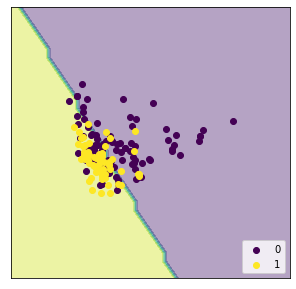

In [17]:
#Vemos la frontera de decisión
plotDecisionBoundary(haha_clf,train, y_train)

In [10]:
#Predecimos las etiqueta del conjunto de prueba
haha_yp=haha_clf.predict(test)

In [11]:
# Medidas de bondad
print("Recall: ", recall_score(y_test,haha_yp,average='macro'))
print("F1: ", f1_score(y_test,haha_yp,average='macro'))
print("Accuracy: ",accuracy_score(y_test,haha_yp))
print("F1 Humor: ", f1_score(y_test,haha_yp))

Recall:  0.7108108108108109
F1:  0.7069199457259159
Accuracy:  0.7083333333333334
F1 Humor:  0.7272727272727272


In [34]:
print(NearestCentroid(distance='coseno',centroid_type='Average').__class__.__name__)
print(vars(NearestCentroid(distance='coseno',centroid_type='Average')))

NearestCentroid
{'distance': <function coseno at 0x7fd4d8f529e0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fd4cc495950>>, 'kwargs_': {}}


===  NearestCentroid: {'distance': <function coseno at 0x7fd4cc3beb90>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fd4cc153290>>, 'kwargs_': {}}
Recall:  0.7108108108108109
F1:  0.7069199457259159
Accuracy:  0.7083333333333334
F1 Humor:  0.7272727272727272


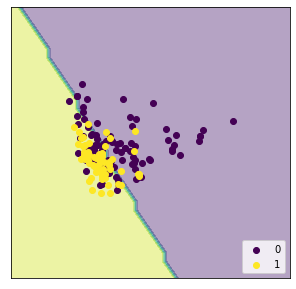

===  NearestCentroid: {'distance': <function coseno at 0x7fd4cc3beb90>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fd4cc5ac9d0>>, 'kwargs_': {}}
Recall:  0.7108108108108109
F1:  0.7069199457259159
Accuracy:  0.7083333333333334
F1 Humor:  0.7272727272727272


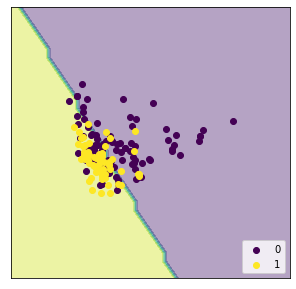

===  NearestCentroid: {'distance': <function coseno at 0x7fd4cc3beb90>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fd4cc5d9050>>, 'kwargs_': {}}
Recall:  0.7243243243243244
F1:  0.7213622291021672
Accuracy:  0.7222222222222222
F1 Humor:  0.736842105263158


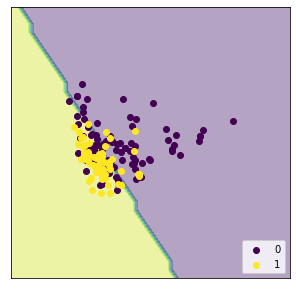

===  NearestCentroid: {'distance': <function coseno at 0x7fd4cc3beb90>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fd4cc315cd0>>, 'kwargs_': {}}
Recall:  0.7108108108108109
F1:  0.7069199457259159
Accuracy:  0.7083333333333334
F1 Humor:  0.7272727272727272


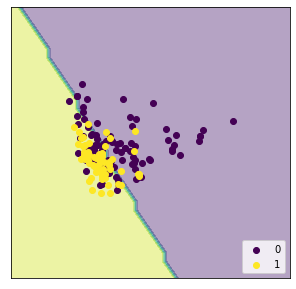

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fd5045018d0>>, 'distance': 'coseno', 'k': 5}
Recall:  0.6776061776061776
F1:  0.6754850088183422
Accuracy:  0.6805555555555556
F1 Humor:  0.634920634920635


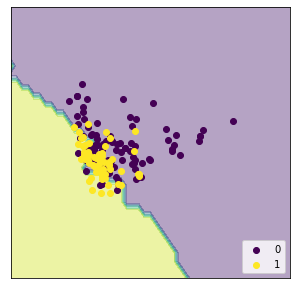

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fd4cc1fccd0>>, 'distance': 'coseno', 'k': 5}
Implementación mean_dist
Recall:  0.6123552123552123
F1:  0.6108108108108108
Accuracy:  0.6111111111111112
F1 Humor:  0.6216216216216216
Implementación mean_dist


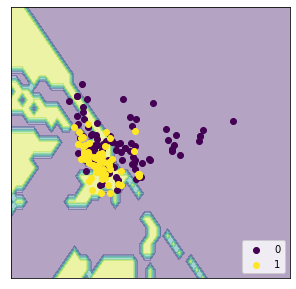

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fd4cc318710>>, 'distance': 'coseno', 'k': 5}
Implementación weighed_dist
Recall:  0.6776061776061776
F1:  0.6754850088183422
Accuracy:  0.6805555555555556
F1 Humor:  0.634920634920635
Implementación weighed_dist


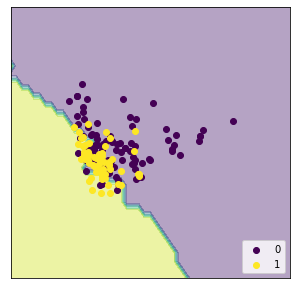

===  NearestCentroid: {'distance': <function euclidiana at 0x7fd4cc4750e0>, 'algorithm': <bound method NearestCentroid.Average of <skeleton.NearestCentroid object at 0x7fd50446e3d0>>, 'kwargs_': {}}
Recall:  0.7115830115830116
F1:  0.7055501460564753
Accuracy:  0.7083333333333334
F1 Humor:  0.7341772151898734


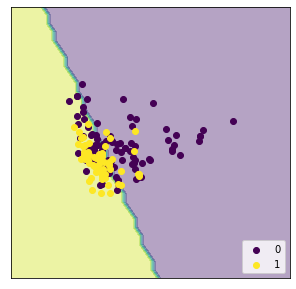

===  NearestCentroid: {'distance': <function euclidiana at 0x7fd4cc4750e0>, 'algorithm': <bound method NearestCentroid.Sum of <skeleton.NearestCentroid object at 0x7fd50445be50>>, 'kwargs_': {}}
Recall:  0.5
F1:  0.32710280373831774
Accuracy:  0.4861111111111111
F1 Humor:  0.6542056074766355


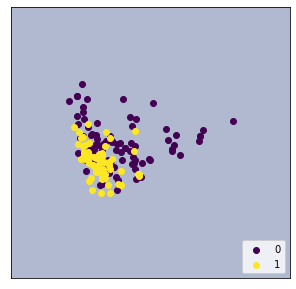

===  NearestCentroid: {'distance': <function euclidiana at 0x7fd4cc4750e0>, 'algorithm': <bound method NearestCentroid.Rocchio of <skeleton.NearestCentroid object at 0x7fd4cc1a7350>>, 'kwargs_': {}}
Recall:  0.5
F1:  0.33944954128440363
Accuracy:  0.5138888888888888
F1 Humor:  0.0


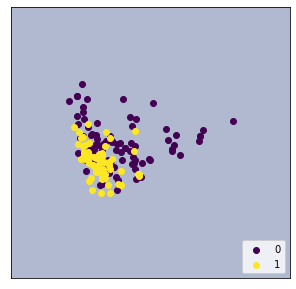

===  NearestCentroid: {'distance': <function euclidiana at 0x7fd4cc4750e0>, 'algorithm': <bound method NearestCentroid.NormSum of <skeleton.NearestCentroid object at 0x7fd4cc2a8fd0>>, 'kwargs_': {}}
Recall:  0.7108108108108109
F1:  0.7069199457259159
Accuracy:  0.7083333333333334
F1 Humor:  0.7272727272727272


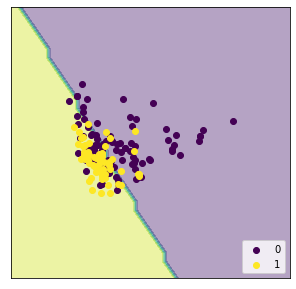

===  kNN: {'weight': <bound method kNN._uniform of <skeleton.kNN object at 0x7fd5155de4d0>>, 'distance': 'euclidiana', 'k': 5}
Recall:  0.6386100386100386
F1:  0.6386100386100386
Accuracy:  0.6388888888888888
F1 Humor:  0.6285714285714286


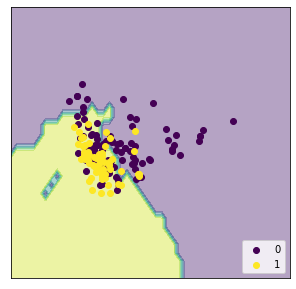

===  kNN: {'weight': <bound method kNN._mean_dist of <skeleton.kNN object at 0x7fd4cc5fe6d0>>, 'distance': 'euclidiana', 'k': 5}
Implementación mean_dist
Recall:  0.6799227799227799
F1:  0.6799999999999999
Accuracy:  0.6805555555555556
F1 Humor:  0.6666666666666666
Implementación mean_dist


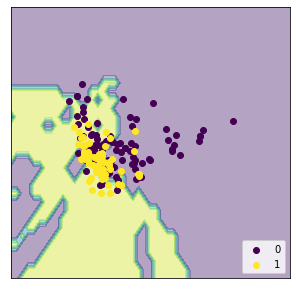

===  kNN: {'weight': <bound method kNN._weighed_dist of <skeleton.kNN object at 0x7fd514900050>>, 'distance': 'euclidiana', 'k': 5}
Implementación weighed_dist
Recall:  0.6386100386100386
F1:  0.6386100386100386
Accuracy:  0.6388888888888888
F1 Humor:  0.6285714285714286
Implementación weighed_dist


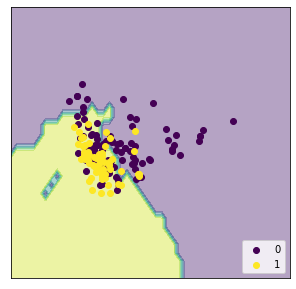

In [52]:
P={} #Performance

P["NC.cos.avg"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Average'),train,y_train,test,y_test)
P["NC.cos.sum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Sum'),train,y_train,test,y_test)
P["NC.cos.rocchio"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='Rocchio'),train,y_train,test,y_test)
P["NC.cos.nsum"]=testClassifier(NearestCentroid(distance='coseno',centroid_type='NormSum'),train,y_train,test,y_test)

P["KNN.cos.u"]=testClassifier(kNN(distance='coseno',k=5,weight_type='uniform'),train,y_train,test,y_test)
P["KNN.cos.m"]=testClassifier(kNN(distance='coseno',k=5,weight_type='mean_dist'),train,y_train,test,y_test)
P["KNN.cos.w"]=testClassifier(kNN(distance='coseno',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)

P["NC.euc.avg"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Average'),train,y_train,test,y_test)
P["NC.euc.sum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Sum'),train,y_train,test,y_test)
P["NC.euc.rocchio"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='Rocchio'),train,y_train,test,y_test)
P["NC.euc.nsum"]=testClassifier(NearestCentroid(distance='euclidiana',centroid_type='NormSum'),train,y_train,test,y_test)

P["KNN.euc.u"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='uniform'),train,y_train,test,y_test)
P["KNN.euc.m"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='mean_dist'),train,y_train,test,y_test)
P["KNN.euc.w"]=testClassifier(kNN(distance='euclidiana',k=5,weight_type='weighed_dist'),train,y_train,test,y_test)

In [59]:
pd.DataFrame(P).T.sort_values("f1_humor",ascending =False)

,recall,f1,accuracy,f1_humor
NC.cos.rocchio,0.724324,0.721362,0.722222,0.736842
NC.euc.avg,0.711583,0.705550,0.708333,0.734177
NC.cos.avg,0.710811,0.706920,0.708333,0.727273
NC.cos.sum,0.710811,0.706920,0.708333,0.727273
NC.cos.nsum,0.710811,0.706920,0.708333,0.727273
NC.euc.nsum,0.710811,0.706920,0.708333,0.727273
KNN.euc.m,0.679923,0.680000,0.680556,0.666667
NC.euc.sum,0.500000,0.327103,0.486111,0.654206
KNN.cos.u,0.677606,0.675485,0.680556,0.634921
KNN.cos.w,0.677606,0.675485,0.680556,0.634921


In [49]:
def testClassifier(clf,train,y_train,test,y_test):
    print("=== ",clf.__class__.__name__,end='')
    print(":",vars(clf))
    clf=clf.fit(train,y_train)
    #Predecimos las etiqueta del conjunto de prueba
    yp=clf.predict(test)
    # Medidas de bondad
    scores={}
    scores['recall']=recall_score(y_test,yp,average='macro')
    scores['f1']=f1_score(y_test,yp,average='macro')
    scores['accuracy']=accuracy_score(y_test,yp)
    scores['f1_humor']=f1_score(y_test,yp)
    print("Recall: ", scores['recall'])
    print("F1: ", scores['f1'])
    print("Accuracy: ", scores['accuracy'])
    print("F1 Humor: ", scores['f1_humor'])
    #Vemos la frontera de decisión
    plotDecisionBoundary(clf,train, y_train)
    return scores

In [12]:
#Ahora probamos el clasificador kNN con pesado uniforme
haha_clfk=kNN(distance='coseno',k=5,weight_type='uniform').fit(train,y_train)

In [13]:
#Predecimos
haha_ypk=haha_clfk.predict(test)

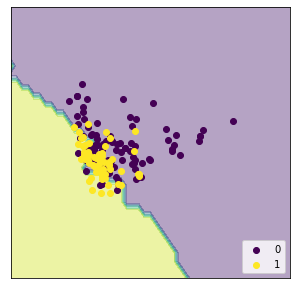

In [15]:
#Frontera de decisión
plotDecisionBoundary(haha_clfk,train,y_train)

In [14]:
# Medidas de bondad
print("Recall: ", recall_score(y_test,haha_ypk,average='macro'))
print("F1: ", f1_score(y_test,haha_ypk,average='macro'))
print("Accuracy: ", accuracy_score(y_test,haha_ypk))
print("F1 Humor: ", f1_score(y_test,haha_ypk))

Recall:  0.6776061776061776
F1:  0.6754850088183422
Accuracy:  0.6805555555555556
F1 Humor:  0.634920634920635
